# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [6]:
from sklearn import model_selection

diabetes_data = pd.read_csv(r"C:\Users\hachi\Downloads\diabetes_data.csv", sep=",")

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(diabetes_train_x, diabetes_train_y)
y_pred = model.predict(diabetes_test_x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


and we compute the accuracy score to evaluate the model performance:

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.8020833333333334

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [10]:
from math import exp
import numpy as np

class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        try:
            a = 1/(1+np.exp(-z))
        except:
            a = np.exp(z)/(1+np.exp(z))
        return a

    def fit(self, X, y, start, lr=1e-1, bsize=50, max_iter=500):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        self.lr_ = lr
        self.bsize_ = bsize
        
        def f_lr(beta):
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
            return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
        
        self.coef_history_.append(start)
        self.f_history_.append(f_lr(beta=start))
        
        
        for step in range(max_iter):
            # Pick random batch of observations
            idx = np.random.randint(n, size=self.bsize_)
            
            # Calculate the gradient for the batch
            last_beta = self.coef_history_[-1]
            sub_gradient = 0
            for i in idx:
                sub_gradient += -y[i] * self.logistic(-y[i]*np.dot(last_beta, X[i, :])) * X[i, :]
            sub_gradient += self.alpha_ * last_beta
            
            # Update the value of beta
            new_beta = last_beta - self.lr_ * sub_gradient
            
            self.coef_history_.append(new_beta)
            self.f_history_.append(f_lr(beta=new_beta))        
        
        self.coef_ = self.coef_history_[-1]
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        
        return -1 + 2 * (self.logistic(np.dot(X, self.coef_)) > 0.5)

Apply to the data

In [11]:
model = StochasticLogisticRegression(alpha=0.5)
model.fit(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(diabetes_train_x.shape[1]), lr=1e-5, bsize=70, max_iter=500)

<ipython-input-10-af0ebba1808a>:60: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
<ipython-input-10-af0ebba1808a>:33: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


In [12]:
y_test_pred = model.predict(diabetes_test_x)
accuracy_score(diabetes_test_y, y_test_pred)

0.65625

##### There's a big drop in accuracy comparing to sklearn's method.
##### Maybe the probabilities are not correctly computed or the threshold needs to be tuned

### Evolution of cost function for different l_r strategies
##### For the chosen l_r :

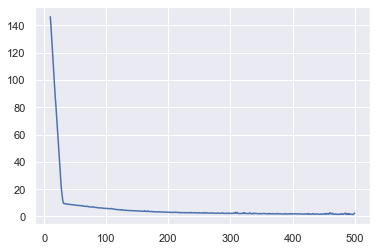

In [13]:
plt.plot(model.f_history_)

##### The SGD algorithm converges before the maximum number of iterations is attained

##### If we set l_r too big :

<ipython-input-10-af0ebba1808a>:60: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
<ipython-input-10-af0ebba1808a>:33: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


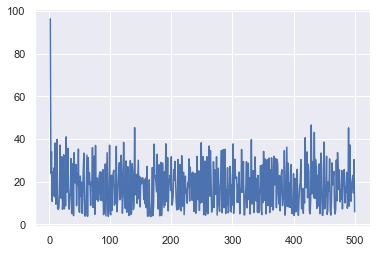

In [15]:
model_1 = StochasticLogisticRegression(alpha=0.5)
model_1.fit(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(diabetes_train_x.shape[1]), lr=1e-4, bsize=70, max_iter=500)

plt.plot(model_1.f_history_)

#### The algorithm is not stable

##### If we set l_r  smaller :

<ipython-input-10-af0ebba1808a>:60: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
<ipython-input-10-af0ebba1808a>:33: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


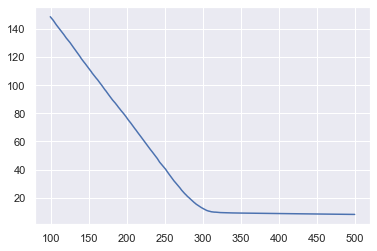

In [16]:
model_2 = StochasticLogisticRegression(alpha=0.5)
model_2.fit(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(diabetes_train_x.shape[1]), lr=1e-6, bsize=70, max_iter=500)
plt.plot(model_2.f_history_)

##### The algorithm converges but the convergence is slower than with l_r = 1e-5

Implement only one acceleration method and compare the results

### We implement the Momentum acceleration method where :
#### beta(t+1) = beta(t) - l_r * grad_f(beta(t)) + theta * (beta(t)-beta(t-1))

In [17]:
class SLR_Momentum():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        try:
            a = 1/(1+np.exp(-z))
        except:
            a = np.exp(z)/(1+np.exp(z))
        return a
    

    def fit(self, X, y, start, lr=1e-1, bsize=50, max_iter=500, theta=0.2):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        self.lr_ = lr
        self.bsize_ = bsize
        
        def f_lr(beta):
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
            return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
        
        self.coef_history_.append(start)
        self.f_history_.append(f_lr(beta=start))
        
        
        for step in range(max_iter):
            # Same steps
            idx = np.random.randint(n, size=self.bsize_)
            sampled_obs = X[idx, :]
            
            last_beta = self.coef_history_[-1]
            sub_gradient = 0
            for i in idx:
                sub_gradient += -y[i] * self.logistic(-y[i]*np.dot(last_beta, X[i, :])) * X[i, :]
            sub_gradient += self.alpha_ * last_beta
            new_beta = last_beta - self.lr_ * sub_gradient
            
            # Add momentum
            if step >= 1:
                new_beta += theta * (self.coef_history_[-1] - self.coef_history_[-2])
            
            self.coef_history_.append(new_beta)
            self.f_history_.append(f_lr(beta=new_beta))        
        
        self.coef_ = self.coef_history_[-1]
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        
        return -1 + 2 * (self.logistic(np.dot(X, self.coef_)) > 0.5)

In [18]:
model_momentum = SLR_Momentum(alpha=0.5)
model_momentum.fit(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(diabetes_train_x.shape[1]), lr=1e-5, bsize=70, max_iter=500, theta=0.2)

y_test_pred = model_momentum.predict(diabetes_test_x)
accuracy_score(diabetes_test_y, y_test_pred)

<ipython-input-17-4d90cf7f173c>:58: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
<ipython-input-17-4d90cf7f173c>:30: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


0.6614583333333334

#### The accuracy is almost the same
#### Let's see what happens with l_r = 1e-6 for the convergence speed

<ipython-input-17-4d90cf7f173c>:58: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(-np.multiply(y, (np.dot(X, beta))))).sum()/X.shape[0] + (self.alpha_/2) * np.multiply(beta, beta).sum()
<ipython-input-17-4d90cf7f173c>:30: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


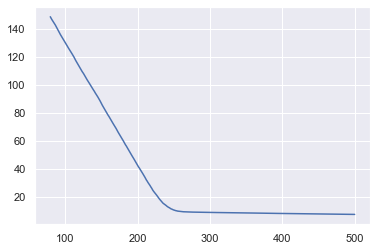

In [20]:
model_momentum = SLR_Momentum(alpha=0.5)
model_momentum.fit(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(diabetes_train_x.shape[1]), lr=1e-6, bsize=70, max_iter=500, theta=0.2)
plt.plot(model_momentum.f_history_)

#### The SGD starts converging after ~250 iterations with the momentum method. This convergence started after around ~300 iterations without the momentum method (see above).

### The algorithm converges faster with the momentum method for the same learning rate while giving the same accuracy.